<a href="https://colab.research.google.com/github/Foluwa/YORUBA-HANDWRITTEN-CHARACTER-RECOGNITION/blob/main/yoruba_alphabets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !bash
# Clone repo
# https://github.com/abdullahtarek/Turkish_digits_classification
# !git clone https://github.com/Foluwa/YORUBA-HANDWRITTEN-CHARACTER-RECOGNITION.git

In [2]:
!git clone https://github.com/Foluwa/YORUBA-HANDWRITTEN-CHARACTER-RECOGNITION.git
!unzip YORUBA-HANDWRITTEN-CHARACTER-RECOGNITION/datasets.zip -d './'

Streaming output truncated to the last 5000 lines.
  inflating: ./datasets/YARS TRAINING DATASET/B/B_84.JPG  
  inflating: ./datasets/YARS TRAINING DATASET/B/B_85.JPG  
  inflating: ./datasets/YARS TRAINING DATASET/B/B_86.JPG  
  inflating: ./datasets/YARS TRAINING DATASET/B/B_87.JPG  
  inflating: ./datasets/YARS TRAINING DATASET/B/B_88.JPG  
  inflating: ./datasets/YARS TRAINING DATASET/B/B_89.JPG  
  inflating: ./datasets/YARS TRAINING DATASET/B/B_9.JPG  
  inflating: ./datasets/YARS TRAINING DATASET/B/B_90.JPG  
  inflating: ./datasets/YARS TRAINING DATASET/B/B_91.JPG  
  inflating: ./datasets/YARS TRAINING DATASET/B/B_92.JPG  
  inflating: ./datasets/YARS TRAINING DATASET/B/B_93.JPG  
  inflating: ./datasets/YARS TRAINING DATASET/B/B_94.JPG  
  inflating: ./datasets/YARS TRAINING DATASET/B/B_95.JPG  
  inflating: ./datasets/YARS TRAINING DATASET/B/B_96.JPG  
  inflating: ./datasets/YARS TRAINING DATASET/B/B_97.JPG  
  inflating: ./datasets/YARS TRAINING DATASET/B/B_98.JPG  
  infl

### Todo:

1. Add Unknown class

In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [4]:
%load_ext tensorboard

In [13]:
class YARSClassifier:
    def __init__(self, base_dir, image_size=(150, 150), batch_size=32):
        self.base_dir = base_dir
        self.train_dir = os.path.join(base_dir, 'YARS TRAINING DATASET')
        self.validation_dir = os.path.join(base_dir, 'YARS TESTING DATASET')
        self.image_size = image_size
        self.batch_size = batch_size
        self.model = None
        self.train_generator = None
        self.validation_generator = None
        self.history = None

    def create_image_generators(self):
        """Create ImageDataGenerators for training and validation."""
        train_datagen = ImageDataGenerator(rescale=1.0/255.0)
        validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

        self.train_generator = train_datagen.flow_from_directory(
            self.train_dir,
            target_size=self.image_size,
            batch_size=self.batch_size,
            class_mode='categorical',
            shuffle=True
        )

        self.validation_generator = validation_datagen.flow_from_directory(
            self.validation_dir,
            target_size=self.image_size,
            batch_size=self.batch_size,
            class_mode='categorical',
            shuffle=False
        )

    # def create_image_generators(self):
    #     """Create ImageDataGenerators for training and validation with data augmentation."""
    #     train_datagen = ImageDataGenerator(
    #         rescale=1.0/255.0,
    #         rotation_range=20,
    #         width_shift_range=0.2,
    #         height_shift_range=0.2,
    #         shear_range=0.2,
    #         zoom_range=0.2,
    #         horizontal_flip=True,
    #         fill_mode='nearest'
    #     )

    #     validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

    #     self.train_generator = train_datagen.flow_from_directory(
    #         self.train_dir,
    #         target_size=self.image_size,
    #         batch_size=self.batch_size,
    #         class_mode='categorical',
    #         shuffle=True
    #     )

    #     self.validation_generator = validation_datagen.flow_from_directory(
    #         self.validation_dir,
    #         target_size=self.image_size,
    #         batch_size=self.batch_size,
    #         class_mode='categorical',
    #         shuffle=False
    #     )

    def build_model(self):
        """Build a Convolutional Neural Network model."""
        input_shape = self.image_size + (3,)
        num_classes = self.train_generator.num_classes

        self.model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(512, activation='relu'),
            Dense(num_classes, activation='softmax')
        ])
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    def train(self, epochs=10):
        """Train the model."""
        if self.model is None:
            raise ValueError("Model not built. Call build_model() first.")

        self.history = self.model.fit(
            self.train_generator,
            epochs=epochs,
            validation_data=self.validation_generator
        )
        return self.history

    def evaluate(self):
        """Evaluate the model on the validation set."""
        if self.model is None:
            raise ValueError("Model not built. Call build_model() first.")

        loss, accuracy = self.model.evaluate(self.validation_generator)
        return loss, accuracy

    def predict(self):
        """Make predictions on the validation set."""
        if self.model is None:
            raise ValueError("Model not built. Call build_model() first.")

        predictions = self.model.predict(self.validation_generator)
        y_pred = np.argmax(predictions, axis=1)
        y_true = self.validation_generator.classes
        return y_true, y_pred

    def plot_confusion_matrix(self, y_true, y_pred):
        """Plot confusion matrix."""
        class_labels = list(self.validation_generator.class_indices.keys())
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(25, 25))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    def plot_training_history(self):
        """Plot training and validation loss."""
        if self.history is None:
            raise ValueError("Model not trained. Call train() first.")

        plt.figure(figsize=(12, 4))

        # Plot training & validation loss values
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')

        # Plot training & validation accuracy values
        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['accuracy'])
        plt.plot(self.history.history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='lower right')

        plt.tight_layout()
        plt.show()

    def predict_single_image(self, image_path, top_k=3):
        """
        Predict the top k classes for a single image.

        Args:
        image_path (str): Path to the image file.
        top_k (int): Number of top classes to return. Default is 3.

        Returns:
        list of tuples: Top k predicted class labels and their probabilities.
        """
        if self.model is None:
            raise ValueError("Model not built. Call build_model() first.")

        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image file not found: {image_path}")

        # Load and preprocess the image
        img = load_img(image_path, target_size=self.image_size)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Create a batch
        img_array /= 255.0  # Rescale the image

        # Make prediction
        predictions = self.model.predict(img_array)[0]

        # Get class labels
        class_labels = list(self.validation_generator.class_indices.keys())

        # Sort predictions and get top k
        top_k_indices = predictions.argsort()[-top_k:][::-1]
        top_k_predictions = [
            (class_labels[i], float(predictions[i]))
            for i in top_k_indices
        ]

        return top_k_predictions

    def convert_to_tflite(self, quantize=False, output_path='model.tflite'):
        """
        Convert the trained model to TensorFlow Lite format.

        Args:
        quantize (bool): Whether to quantize the model. Default is False.
        output_path (str): Path to save the TFLite model. Default is 'model.tflite'.

        Returns:
        str: Path to the saved TFLite model.
        """
        if self.model is None:
            raise ValueError("Model not built. Call build_model() first.")

        # Create a converter
        converter = tf.lite.TFLiteConverter.from_keras_model(self.model)

        if quantize:
            # Quantize the model to reduce size
            # and improve CPU and hardware accelerator latency
            converter.optimizations = [tf.lite.Optimize.DEFAULT]

        # Convert the model
        tflite_model = converter.convert()

        # Save the model
        with open(output_path, 'wb') as f:
            f.write(tflite_model)

        print(f"TensorFlow Lite model saved to: {output_path}")
        return output_path

    def save_model(self, model_path):
        """Save the trained model to a file."""
        if self.model is None:
            raise ValueError("Model not built. Call build_model() first.")

        self.model.save(model_path)
        print(f"Model saved to {model_path}")

In [14]:
base_dir = './datasets/'

# Initialize the classifier
classifier = YARSClassifier(base_dir)

# Prepare data
classifier.create_image_generators()

# Build model
classifier.build_model()

# Print model summary
classifier.model.summary()

# Train model
classifier.train(epochs=4)

Found 10500 images belonging to 70 classes.
Found 2100 images belonging to 70 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                 

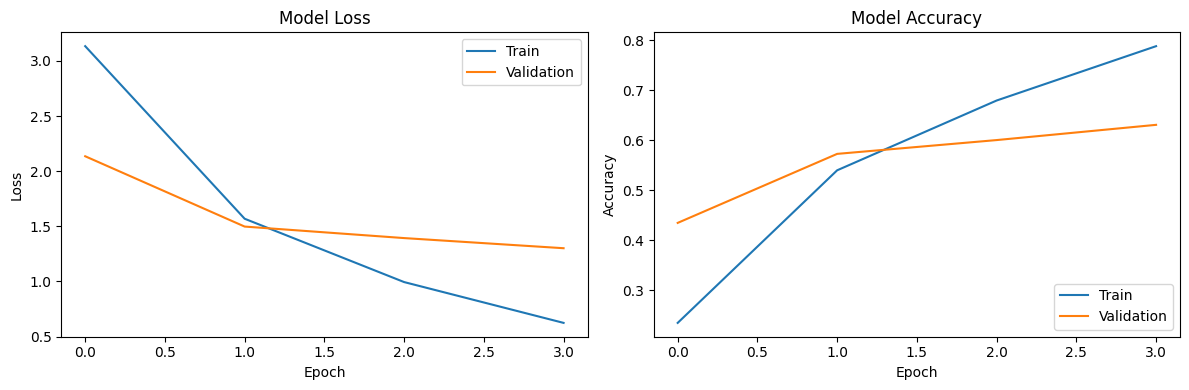

In [15]:
# Plot training history
classifier.plot_training_history()

In [16]:
# Evaluate model
loss, accuracy = classifier.evaluate()
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

66/66 [==============================] - 1s 21ms/step - loss: 1.3015 - accuracy: 0.6310
Validation Loss: 1.3015426397323608
Validation Accuracy: 0.6309523582458496


66/66 [==============================] - 2s 21ms/step


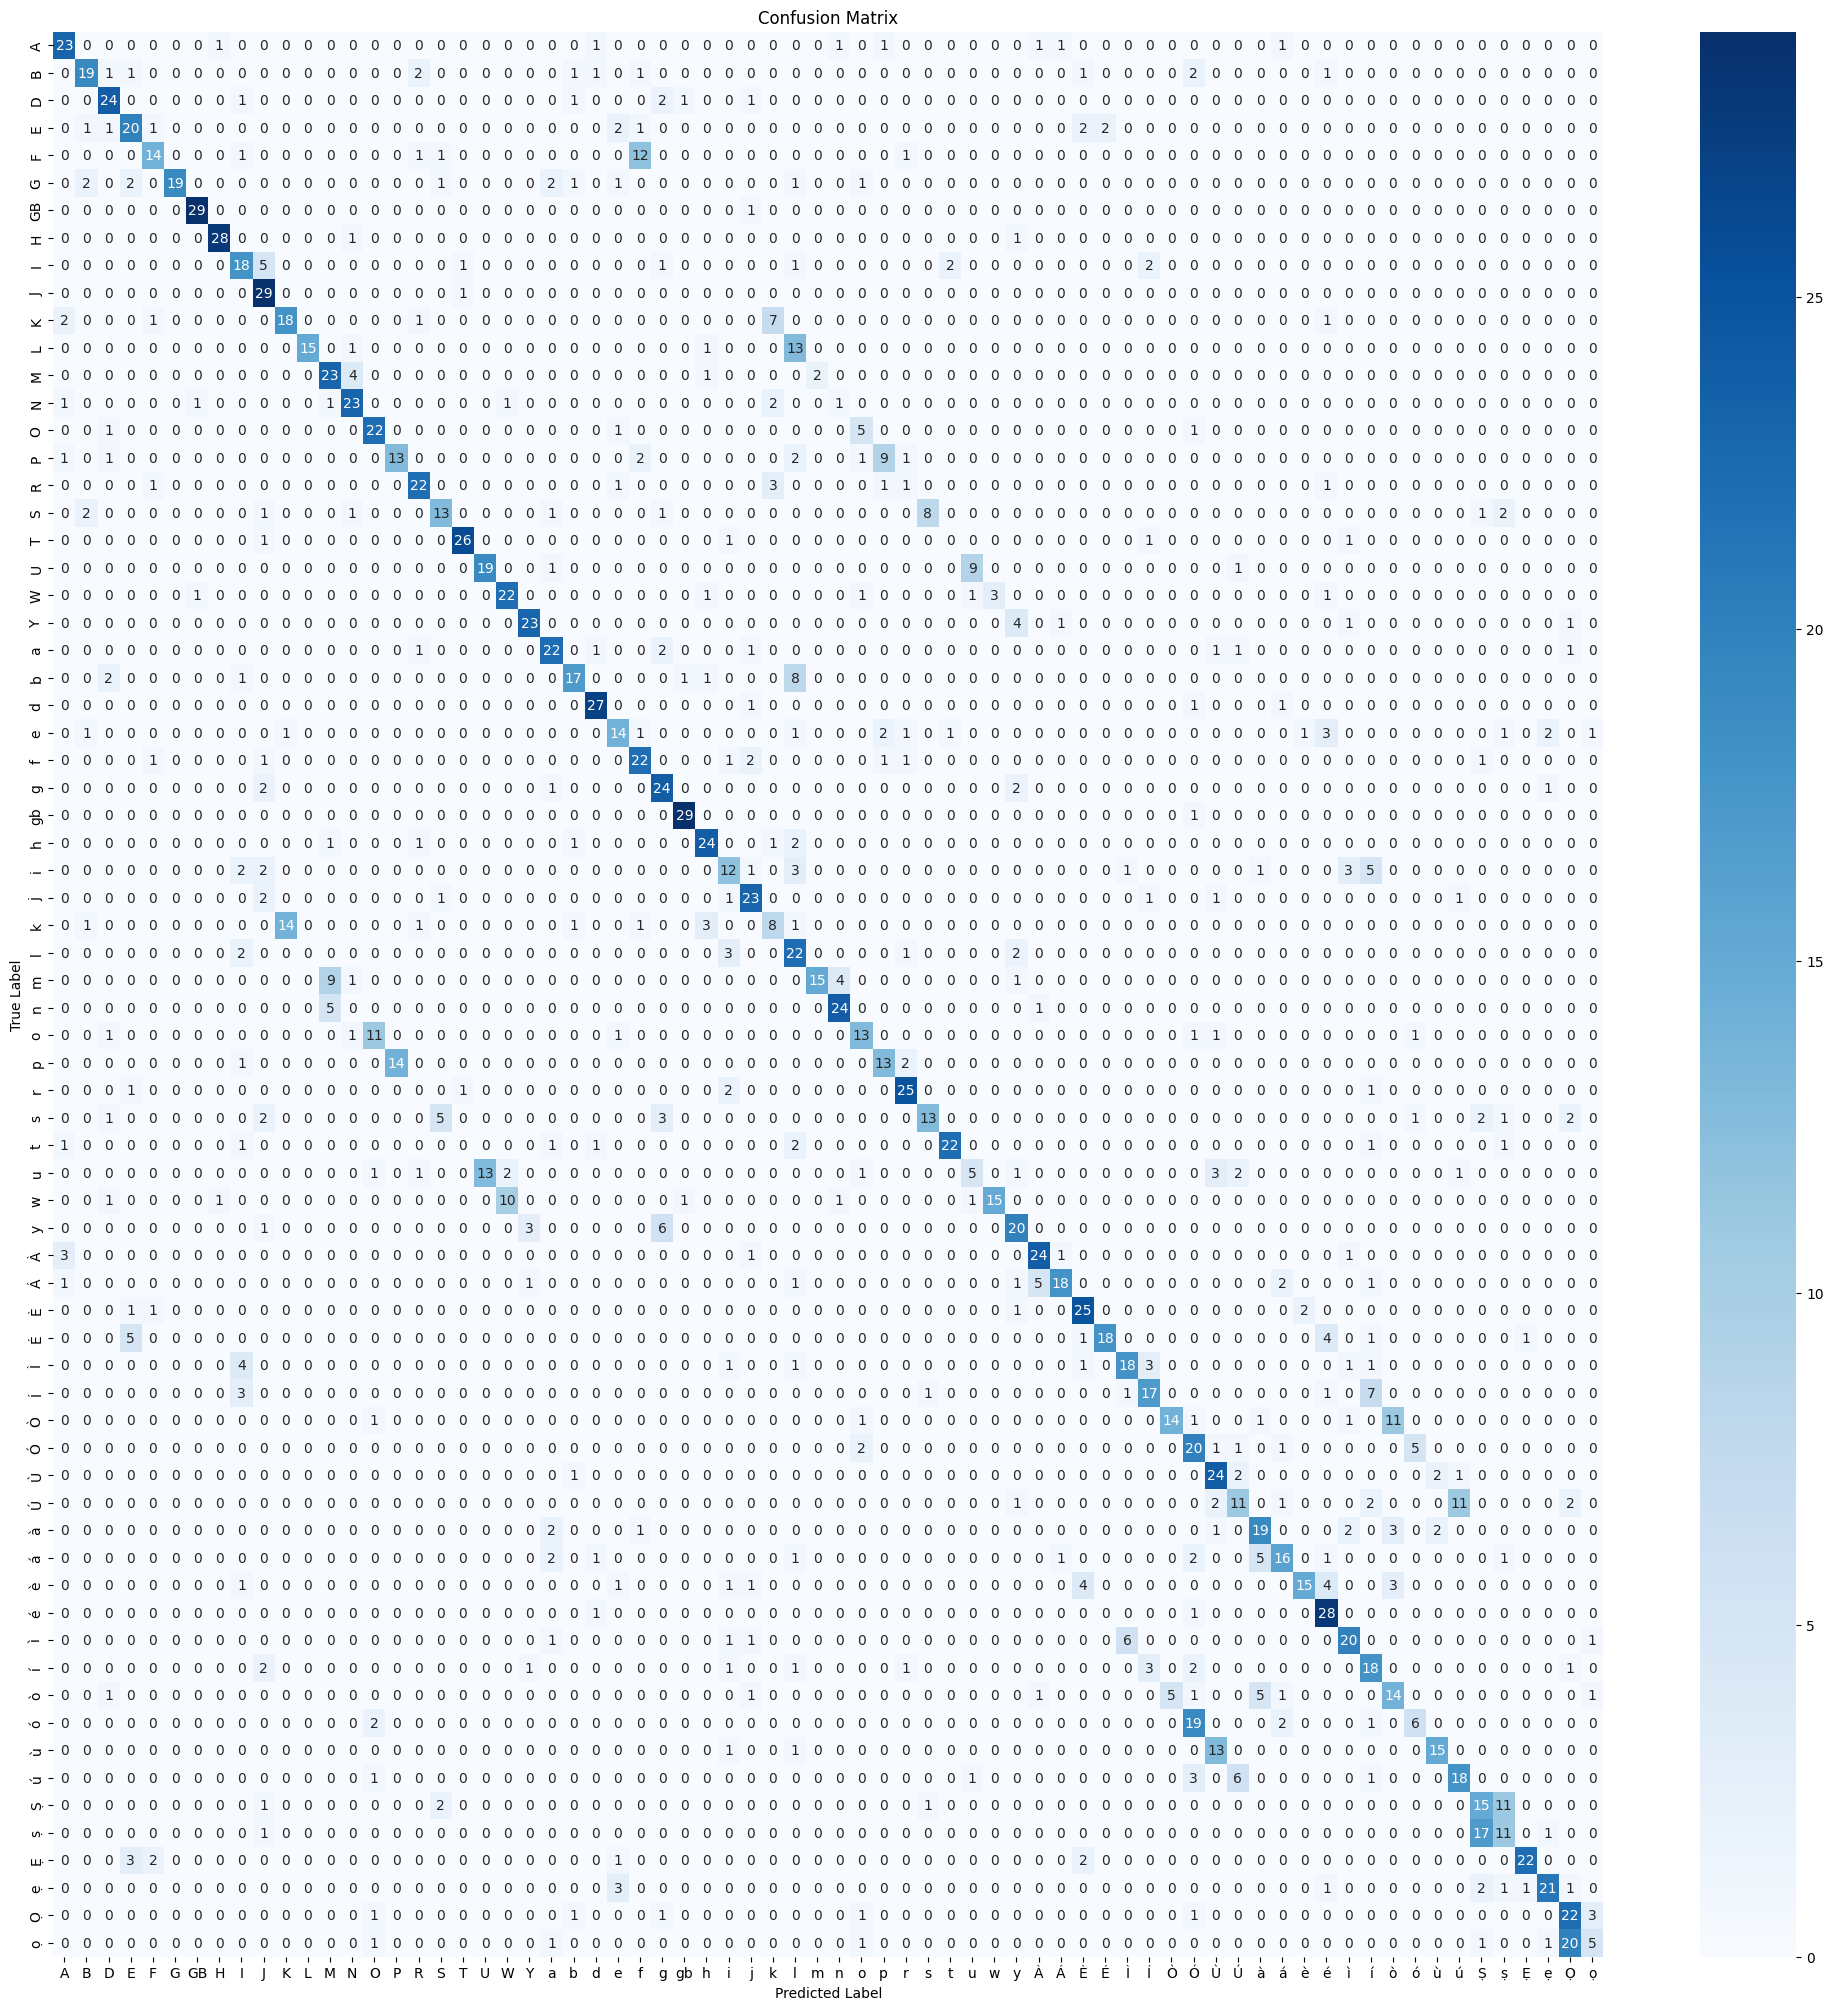

In [17]:
# Make predictions and plot confusion matrix
y_true, y_pred = classifier.predict()
classifier.plot_confusion_matrix(y_true, y_pred)

In [18]:
# Save the model to .h5 format
classifier.save_model('classifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to classifier.h5


1/1 [==============================] - 0s 79ms/step


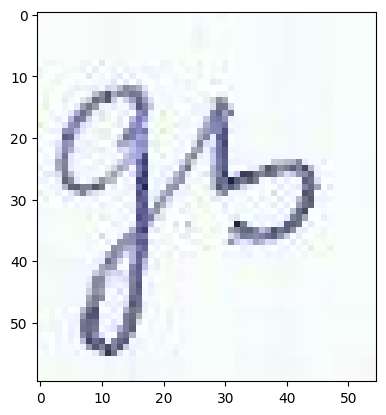

Predictions: {'gb': 0.9834668040275574, 'k': 0.005517290439456701, 'K': 0.0053740618750452995}


In [19]:
# # Predict on a single image
# test_image_path = os.path.join(classifier.validation_dir, 'K', '1.JPG')
# predicted_class, probability = classifier.predict_single_image(test_image_path)
# print(f"Predicted class: {predicted_class}")
# print(f"Probability: {probability:.2f}")


# Predict on a single image
test_image_path = os.path.join(classifier.validation_dir, 'gb', '12.JPG')
top_3_predictions = classifier.predict_single_image(test_image_path)
img = mpimg.imread(test_image_path)
imgplot = plt.imshow(img)
plt.show()

print("Predictions:", dict(top_3_predictions))

In [20]:
# Convert model to TFLite
tflite_model_path = classifier.convert_to_tflite(quantize=True, output_path='yars_model.tflite')
print(f"TFLite model saved to: {tflite_model_path}")

TensorFlow Lite model saved to: yars_model.tflite
TFLite model saved to: yars_model.tflite
